In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as f

spark = SparkSession.builder.enableHiveSupport().getOrCreate()

# Suppresses user warinig messages in Python
import warnings
warnings.simplefilter("ignore", UserWarning)

# Suppresses `WARN` messages in JVM
spark.sparkContext.setLogLevel("ERROR")

NOTE: SPARK_PREPEND_CLASSES is set, placing locally compiled Spark classes ahead of assembly.
21/10/29 21:50:01 WARN Utils: Your hostname, maropus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.3.4 instead (on interface en0)
21/10/29 21:50:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/10/29 21:50:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import importlib
ptesting_model = importlib.import_module("ptesting-model")

In [3]:
expected_input_cols = [                                                                                                                                                                                                                       
    'author',
    'case when length(sha) > 0 then sha else sha(string(random())) end sha',
    'commit_date',
    'array_distinct(failed_tests) failed_tests',
    'files' 
]

log_data_df = spark.read.format('json').load('../models/spark/logs/github-logs.json').selectExpr(expected_input_cols)

In [4]:
log_data_df.orderBy(f.expr('commit_date').desc()).show(3)

+------------+--------------------+-------------------+--------------------+--------------------+
|      author|                 sha|        commit_date|        failed_tests|               files|
+------------+--------------------+-------------------+--------------------+--------------------+
|         c21|9b8b9ef7efa3ab055...|2021/10/26 23:36:54|                  []|[{{10, 10, 0, sql...|
|     xkrogen|bfb98833ddd60db80...|2021/10/26 22:16:21|                  []|[{{9, 18, 9, core...|
|AngersZhuuuu|d03a64cf0b4e5e303...|2021/10/26 14:17:48|[org.apache.spark...|[{{288, 288, 0, s...|
+------------+--------------------+-------------------+--------------------+--------------------+
only showing top 3 rows



In [5]:
import json
from pathlib import Path 
excluded_tests = json.loads(Path('../models/spark/logs/excluded-tests.json').read_text())
log_data_df = ptesting_model._exclude_tests_from(log_data_df, excluded_tests)

In [6]:
from ptesting import github_utils

test_files = json.loads(Path('../models/spark/indexes/latest/test-files.json').read_text())
commits = json.loads(Path('../models/spark/logs/commits.json').read_text())
commits = list(map(lambda c: github_utils.from_github_datetime(c[0]), commits))
updated_file_stats = json.loads(Path('../models/spark/logs/updated-file-stats.json').read_text())
failed_tests = json.loads(Path('../models/spark/failed-tests.json').read_text())
contributor_stats = json.loads(Path('../models/spark/logs/contributor-stats.json').read_text())
dep_graph = json.loads(Path('../models/spark/indexes/latest/dep-graph.json').read_text())

In [7]:
to_train_features, _ = ptesting_model._create_train_test_pipeline(spark, test_files, commits, dep_graph, updated_file_stats, contributor_stats, failed_tests)
pdf = to_train_features.__call__(log_data_df).cache().toPandas()

In [8]:
pdf.dtypes

failed                                  int32
num_commits                             int32
updated_num_3d                          int32
updated_num_14d                         int32
updated_num_56d                         int32
updated_num_3c                          int32
updated_num_14c                         int32
updated_num_56c                         int32
num_adds                                int32
num_dels                                int32
num_chgs                                int32
file_card                               int32
failed_num_7d                           int32
failed_num_14d                          int32
failed_num_28d                          int32
failed_num_7c                           int32
failed_num_14c                          int32
failed_num_28c                          int32
total_failed_num                        int32
path_difference                         int32
distance                                int32
total_failed_num__x__num_commits  

In [9]:
from ptesting import train

X = pdf[pdf.columns[pdf.columns != 'failed']]
y = pdf['failed']
X, y = train.rebalance_training_data(X, y, coeff=2.0)
pdf = X.copy(deep=True)
pdf['failed'] = y

2021-10-29 21:52:59.568 INFO train: Sampling training data (strategy={0: 2066, 1: 1033}): {0: 160764, 1: 1033} => {0: 2066, 1: 1033}


In [10]:
X.describe()

,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,num_dels,num_chgs,...,failed_num_7d__x__num_chgs,failed_num_7d__x__updated_num_56d,failed_num_7d__x__updated_num_56c,failed_num_7d__x__path_difference,failed_num_7d__x__distance,distance__x__num_commits,distance__x__num_chgs,distance__x__updated_num_56d,distance__x__updated_num_56c,distance__x__path_difference
count,3099.000000,3099.000000,3099.000000,3099.000000,3099.000000,3099.000000,3099.000000,3099.000000,3099.000000,3099.000000,...,3099.000000,3099.000000,3099.000000,3099.000000,3099.000000,3099.000000,3.099000e+03,3099.000000,3099.000000,3099.000000
mean,84.417877,2.263311,6.361730,14.712488,0.357535,0.612456,3.420136,1561.868667,199.998709,1761.867377,...,113.954501,5.731526,1.743143,1.340755,26.600516,2938.959664,1.744800e+04,621.538884,229.139400,135.089384
std,138.157639,3.744552,7.528288,14.746829,1.748175,2.140449,4.541644,11972.626942,841.530980,12157.728962,...,962.851407,12.050901,3.249648,3.323244,52.456405,7611.285319,3.209397e+05,1202.294976,470.138645,548.150765
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,48.000000,7.000000,55.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.200000e+02,3.000000,0.000000,7.000000
50%,0.000000,0.000000,3.000000,13.000000,0.000000,0.000000,2.000000,109.000000,15.000000,141.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.790000e+02,24.000000,3.000000,12.000000
75%,91.000000,3.000000,11.000000,20.000000,0.000000,1.000000,6.000000,210.000000,59.000000,308.000000,...,55.000000,7.000000,1.000000,2.000000,1.000000,634.000000,7.040000e+03,128.000000,26.000000,128.000000
max,887.000000,25.000000,38.000000,117.000000,20.000000,21.000000,31.000000,130829.000000,9386.000000,132030.000000,...,23384.000000,200.000000,16.000000,128.000000,384.000000,113536.000000,1.689984e+07,14976.000000,3968.000000,16384.000000


In [11]:
# import featuretools as ft
# es = ft.EntitySet(id='ptesting_model')
# es = es.entity_from_dataframe(entity_id='github_logs', dataframe=X, index='uid', make_index=True)
# X, _ = ft.dfs(entityset=es, target_entity='github_logs', trans_primitives=['multiply_numeric'], agg_primitives=[], max_depth=1)

In [12]:
def to_histogram_seaborn_numeirc_only(X):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    fig = plt.figure(figsize=(20, 16))
    return X.hist(ax=fig.gca())

array([[<AxesSubplot:title={'center':'num_commits'}>,
        <AxesSubplot:title={'center':'updated_num_3d'}>,
        <AxesSubplot:title={'center':'updated_num_14d'}>,
        <AxesSubplot:title={'center':'updated_num_56d'}>,
        <AxesSubplot:title={'center':'updated_num_3c'}>,
        <AxesSubplot:title={'center':'updated_num_14c'}>],
       [<AxesSubplot:title={'center':'updated_num_56c'}>,
        <AxesSubplot:title={'center':'num_adds'}>,
        <AxesSubplot:title={'center':'num_dels'}>,
        <AxesSubplot:title={'center':'num_chgs'}>,
        <AxesSubplot:title={'center':'file_card'}>,
        <AxesSubplot:title={'center':'failed_num_7d'}>],
       [<AxesSubplot:title={'center':'failed_num_14d'}>,
        <AxesSubplot:title={'center':'failed_num_28d'}>,
        <AxesSubplot:title={'center':'failed_num_7c'}>,
        <AxesSubplot:title={'center':'failed_num_14c'}>,
        <AxesSubplot:title={'center':'failed_num_28c'}>,
        <AxesSubplot:title={'center':'total_failed_nu

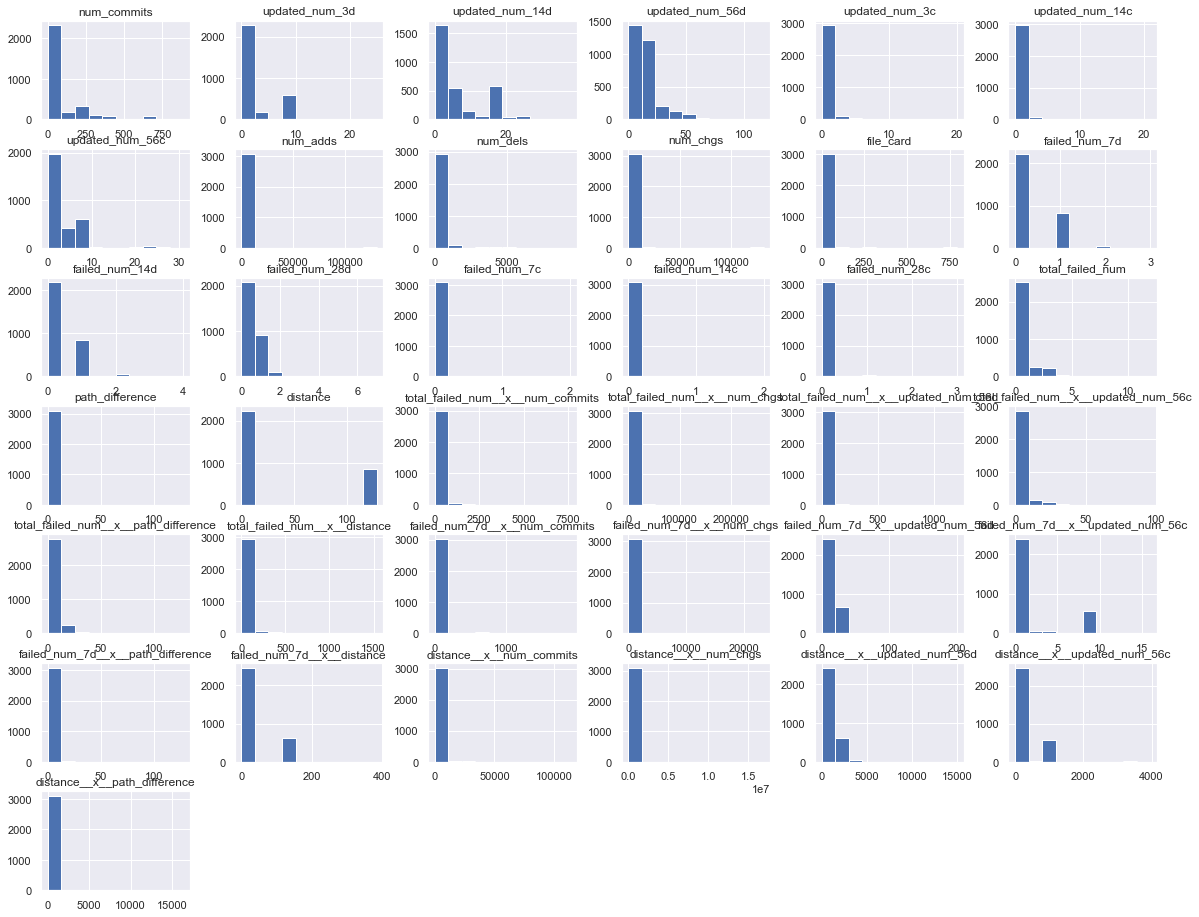

In [13]:
to_histogram_seaborn_numeirc_only(X)

In [14]:
def to_splom_altair(X, target):
    import altair as alt
    chart = alt.Chart(X).mark_circle().encode(
        alt.X(alt.repeat("column"), type='quantitative'),
        alt.Y(alt.repeat("row"), type='quantitative'),
        color=f'{target}:N'
    )
    chart = chart.properties(width=100, height=100)
    chart = chart.repeat(
        row=X.columns.tolist(),
        column=X.columns.tolist()
    )
    return chart

In [15]:
to_splom_altair(pdf, target='failed')

alt.RepeatChart(...)

In [16]:
def to_corr_heatmap(X):    
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.heatmap(X.corr(method='pearson'), vmax=1, vmin=-1, center=0, ax=fig.gca())

<AxesSubplot:>

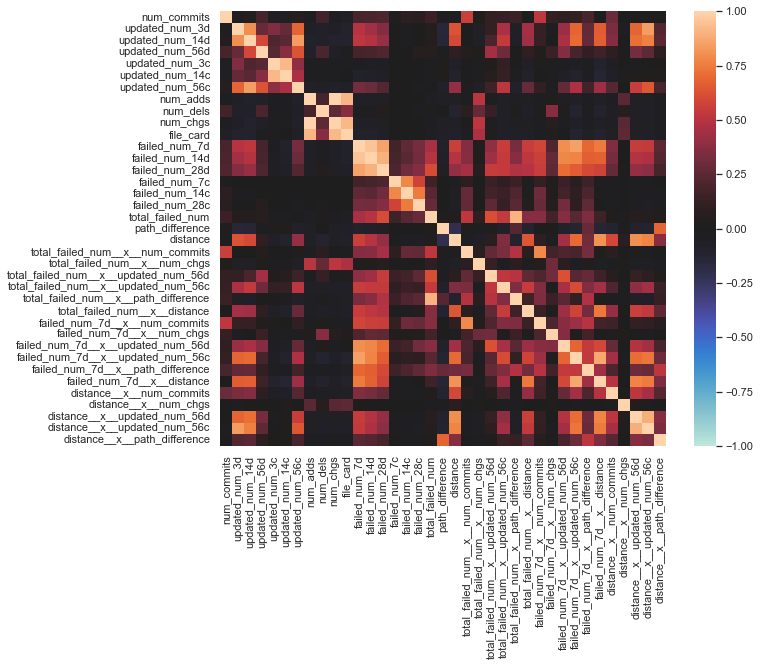

In [17]:
to_corr_heatmap(X)

In [18]:
def compute_mi_between_features(X):
    from minepy import MINE
    results = []
    mine = MINE(alpha=0.6, c=15, est="mic_approx")

    import itertools
    for c1, c2 in itertools.combinations(X.columns, 2):
        mine.compute_score(X[c1], X[c2])
        results.append(((c1, c2), mine.mic()))

    return sorted(results, key=lambda x: x[1], reverse=True)

In [19]:
mi_between_fts = compute_mi_between_features(X)
print(mi_between_fts[0:3])

[(('num_adds', 'num_chgs'), 0.9794044298869856), (('total_failed_num', 'total_failed_num__x__num_chgs'), 0.9490152293630466), (('num_commits', 'distance__x__num_commits'), 0.9453965579732775)]


In [20]:
def compute_mi_against(target, X):
    from minepy import MINE
    results = []
    mine = MINE(alpha=0.6, c=15, est="mic_approx")

    for c in X.columns:
        mine.compute_score(y, X[c])
        results.append(((target, c), mine.mic()))

    return sorted(results, key=lambda x: x[1], reverse=True)

In [21]:
mi_against_target = compute_mi_against('failed', X)
selected_features_with_mi = list(map(lambda x: x[0][1], mi_against_target))[0:6]
print(mi_against_target[0:3])

[(('failed', 'total_failed_num__x__num_chgs'), 0.6367388551480142), (('failed', 'distance__x__num_chgs'), 0.6342090294028093), (('failed', 'failed_num_7d__x__num_chgs'), 0.5935084559183433)]


In [22]:
def select_features_with_bruta(X, y, is_discrete=True):
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    from boruta import BorutaPy
    model_class = RandomForestClassifier if is_discrete else RandomForestRegressor
    rf = model_class(n_jobs=-1, max_depth=5)
    rf.fit(X, y)
    print('SCORE with ALL Features: %1.2f' % rf.score(X, y))

    rf = model_class(n_jobs=-1, max_depth=5)
    fs = BorutaPy(rf, n_estimators='auto', random_state=42, perc=80, two_step=False, max_iter=500)
    fs.fit(X.values, y.values)

    selected = fs.support_
    X_selected = X[X.columns[selected]]
    rf = model_class(n_jobs=-1, max_depth=5)
    rf.fit(X_selected, y)
    print('SCORE with selected Features: %1.2f' % rf.score(X_selected, y))
    
    return X.columns[selected]

In [23]:
selected_features_with_bruta = select_features_with_bruta(X, y, is_discrete=True)

SCORE with ALL Features: 0.98
SCORE with selected Features: 0.98


In [24]:
columns_selected = selected_features_with_bruta
# columns_selected = selected_features_with_mi
columns_selected

Index(['num_commits', 'updated_num_3d', 'updated_num_14d', 'updated_num_56d',
       'updated_num_3c', 'updated_num_14c', 'updated_num_56c', 'num_adds',
       'num_dels', 'num_chgs', 'file_card', 'failed_num_7d', 'failed_num_14d',
       'failed_num_28d', 'failed_num_7c', 'failed_num_14c', 'failed_num_28c',
       'total_failed_num', 'path_difference', 'distance',
       'total_failed_num__x__num_commits', 'total_failed_num__x__num_chgs',
       'total_failed_num__x__updated_num_56d',
       'total_failed_num__x__updated_num_56c',
       'total_failed_num__x__path_difference', 'total_failed_num__x__distance',
       'failed_num_7d__x__num_commits', 'failed_num_7d__x__num_chgs',
       'failed_num_7d__x__updated_num_56d',
       'failed_num_7d__x__updated_num_56c',
       'failed_num_7d__x__path_difference', 'failed_num_7d__x__distance',
       'distance__x__num_commits', 'distance__x__num_chgs',
       'distance__x__updated_num_56d', 'distance__x__updated_num_56c',
       'distance__x

In [25]:
X_selected = X[columns_selected]

In [26]:
def to_pca(X, y, target):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    _X = pca.fit_transform(X)
    _X = pd.DataFrame({'PCA-X': _X[:, 0], 'PCA-Y': _X[:, 1], target: y})

    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.scatterplot(data=_X, x='PCA-X', y='PCA-Y', hue=target, ax=fig.gca())

<AxesSubplot:xlabel='PCA-X', ylabel='PCA-Y'>

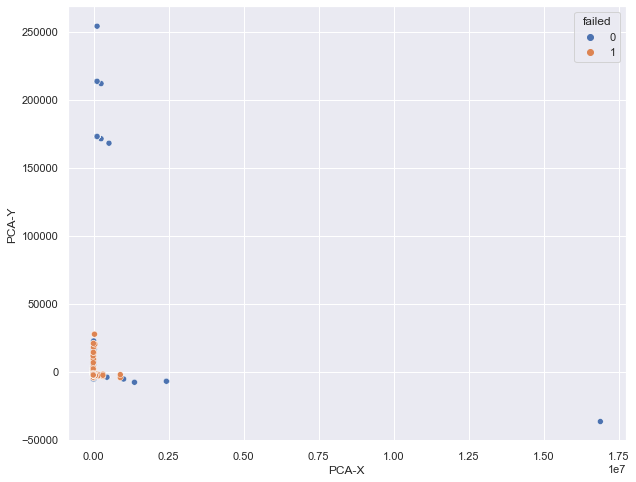

In [27]:
to_pca(X_selected, y, target='failed')

In [28]:
def to_tsne(X, y, target, nsample=100, perplexity=50, n_iter=10000):
    # One of non-linear embedding in sklearn
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=n_iter)
    _pdf = X.copy(deep=True)
    _pdf[target] = y
    _pdf_sampled = _pdf.sample(n=nsample, random_state=42)
    _X = _pdf_sampled[_pdf_sampled.columns[_pdf_sampled.columns != target]]
    _y = _pdf_sampled[target]
    _tf = tsne.fit_transform(_X)
    _X = pd.DataFrame({'tSNE-X': _tf[:, 0], 'tSNE-Y': _tf[:, 1], target: _y})
    print('KL divergence: {}'.format(tsne.kl_divergence_))

    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.scatterplot(data=_X, x='tSNE-X', y='tSNE-Y', hue=target, ax=fig.gca())

KL divergence: 0.07943342626094818


<AxesSubplot:xlabel='tSNE-X', ylabel='tSNE-Y'>

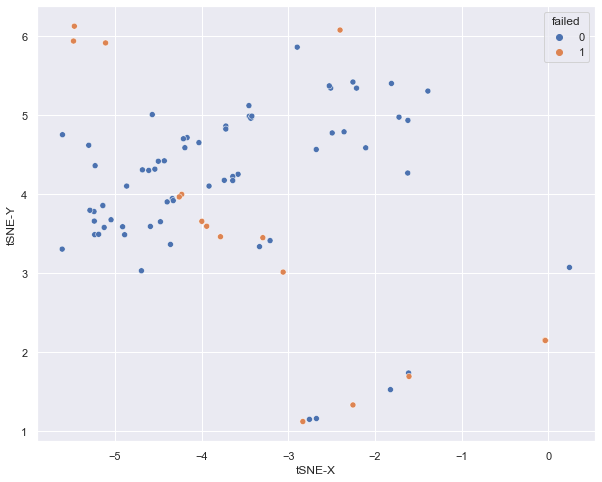

In [29]:
to_tsne(X_selected, y, target='failed', nsample=100, perplexity=50, n_iter=10000)

In [30]:
def to_umap(X, y, target, n_neighbors=5, min_dist=0.3, metric='euclidean'):
    from umap import UMAP
    umap = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    _data = umap.fit_transform(X)
    _X = pd.DataFrame({'tSNE-X': _data[:, 0], 'tSNE-Y': _data[:, 1], target: y})

    import altair as alt
    chart = alt.Chart(_X).mark_point().encode(x='tSNE-X', y='tSNE-Y', color=f'{target}:N').properties(width=600, height=400).interactive()
    return chart

In [31]:
to_umap(X_selected, y, target='failed', n_neighbors=300, min_dist=1.0, metric='euclidean')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


alt.Chart(...)

In [32]:
def reduce_dim(X, y, target, n_components=2, n_neighbors=5, min_dist=0.3, metric='euclidean'):
    from umap import UMAP
    umap = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=42)
    _data = umap.fit_transform(X)
    _columns = list(map(lambda x: f'UMAP-{x}', range(0, n_components)))
    return pd.DataFrame(_data, columns=_columns), umap

In [33]:
# X_selected, _ = reduce_dim(X_selected, y, target='failed', n_components=18, n_neighbors=300, min_dist=1.0, metric='euclidean')

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, stratify=y, test_size=0.33, shuffle=True, random_state=42)

from ptesting import train
params = {'hp.timeout': '3600', 'hp.no_progress_loss': '100'}
clf, score = train.build_model(X_train, y_train, opts=params)
print(f'Score: {score}')

import json
probs = clf.predict_proba(X_test)
pmf = map(lambda p: {"classes": clf.classes_.tolist(), "probs": p.tolist()}, probs)
pmf = map(lambda p: json.dumps(p), pmf)
df = spark.createDataFrame(pd.DataFrame({'y_true': y_test, 'pmf': list(pmf)}))
df = df.selectExpr('y_true', 'from_json(pmf, "classes array<string>, probs array<double>") pmf')
df = df.selectExpr('y_true', 'arrays_zip(pmf.classes, pmf.probs) pmf')
df = df.selectExpr('y_true', 'array_sort(pmf, (left, right) -> if(left.`1` < right.`1`, 1, -1)) pmf')
df = df.selectExpr('y_true', 'pmf[0].`0` y_predicted', 'pmf[0].`1` prob')
df = df.selectExpr('y_true', 'y_predicted', 'prob', 'y_true = y_predicted is_correct')
predicted = df.toPandas()

Score: 0.9761719274057681


In [35]:
predicted[~predicted['is_correct']]

,y_true,y_predicted,prob,is_correct
124,1,0,0.970843,False
165,1,0,0.822352,False
216,1,0,0.550886,False
223,1,0,0.966139,False
225,1,0,0.971207,False
348,0,1,0.671250,False
361,1,0,0.963004,False
414,0,1,0.517891,False
441,1,0,0.683769,False
465,0,1,0.602342,False


In [36]:
print('Accuracy: {}'.format(len(predicted[predicted['is_correct']]) / len(predicted)))

Accuracy: 0.9814271749755621
